In [ ]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
# Paths
data_dir = '/content/drive/MyDrive/Dataset2'
categories = ['normal_wound', 'retonic_acid']


In [ ]:
# Function to load images
def load_images(data_dir, categories):
    dataset = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for folder in os.listdir(category_path):
            folder_path = os.path.join(category_path, folder)
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (128, 128))  # Resize for consistency
                    dataset.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(dataset), np.array(labels)


In [ ]:
# Load dataset
images, labels = load_images(data_dir, categories)
print(f"Loaded {len(images)} images.")


Loaded 336 images.


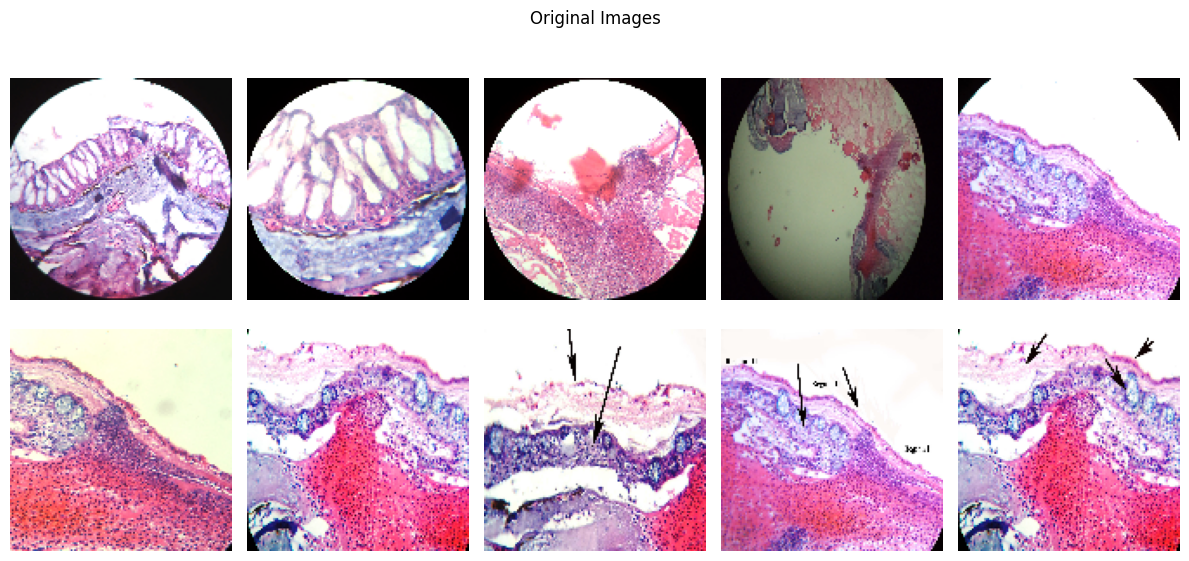

In [ ]:
# Visualize some original images
def visualize_images(images, title, count=10):
    plt.figure(figsize=(12, 6))
    for i in range(min(count, len(images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_images(images, "Original Images")


In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
augmented_images = []
for img in tqdm(images, desc="Augmenting Images"):
    img = img.reshape((1, *img.shape))
    count = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        count += 1
        if count >= 7:
            break

augmented_images = np.array(augmented_images)
print(f"\nAugmented dataset contains {len(augmented_images)} images.")


Augmenting Images: 100%|██████████| 336/336 [00:10<00:00, 30.95it/s]



Augmented dataset contains 2352 images.


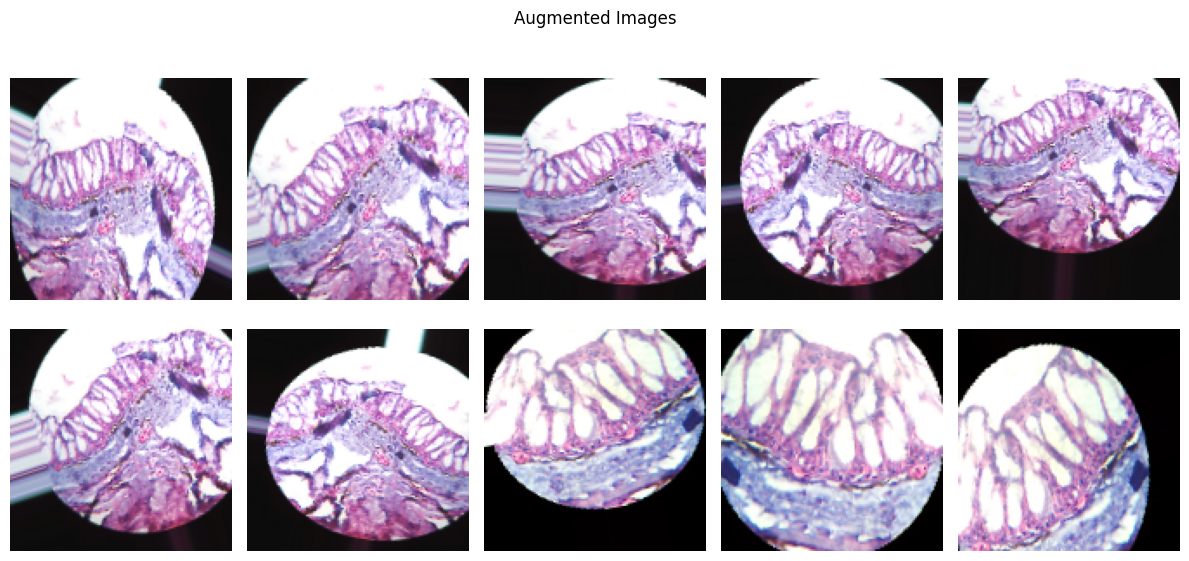

In [ ]:
# Visualize some augmented images
visualize_images(augmented_images, "Augmented Images")

In [ ]:
# Flatten the augmented images for clustering
flat_images = augmented_images.reshape(augmented_images.shape[0], -1)


In [ ]:

# Normalize the images
flat_images = flat_images / 255.0


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Apply PCA to the flattened images
pca = PCA()
pca.fit(flat_images)


PCA()

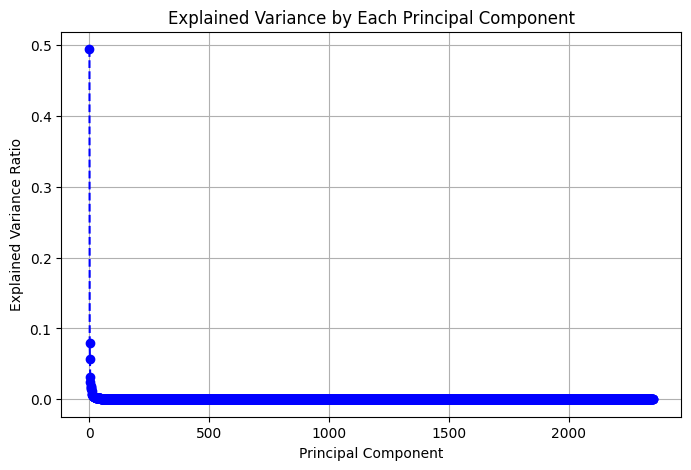

In [ ]:
# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()

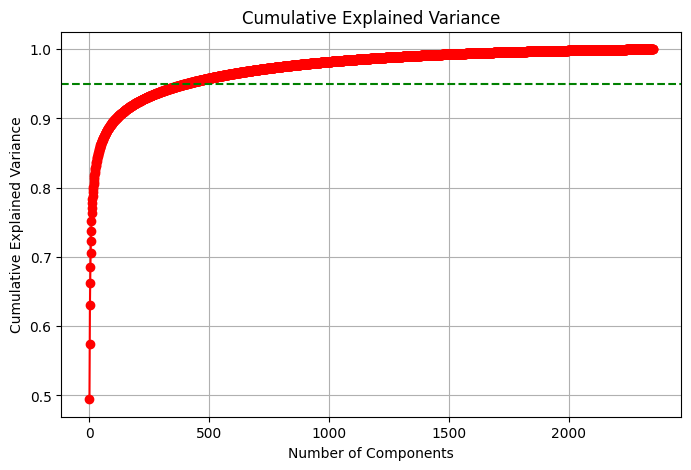

In [ ]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='r')
plt.axhline(y=0.95, color='g', linestyle='--')  # 95% explained variance line
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()



In [ ]:
# Find the number of components that explain 95% of the variance
n_components_95 = (cumulative_variance <= 0.95).sum() + 1
print(f"\nMinimum number of components for 95% variance: {n_components_95}")



Minimum number of components for 95% variance: 403


In [ ]:

# Apply PCA for dimensionality reduction (using 403 components for 95% variance)
pca = PCA(n_components=403)
reduced_data = pca.fit_transform(flat_images)


In [ ]:
# Initialize lists to store results
cluster_range = range(2, 10)  # Test from 2 to 9 clusters
silhouette_scores = []


In [ ]:
# Perform K-Means clustering for different cluster numbers
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(reduced_data)

    # Calculate Silhouette Score
    score = silhouette_score(reduced_data, clusters)
    silhouette_scores.append(score)
    print(f"Clusters: {n_clusters}, Silhouette Score: {score:.2f}")


Clusters: 2, Silhouette Score: 0.36
Clusters: 3, Silhouette Score: 0.21
Clusters: 4, Silhouette Score: 0.19
Clusters: 5, Silhouette Score: 0.17
Clusters: 6, Silhouette Score: 0.14
Clusters: 7, Silhouette Score: 0.13
Clusters: 8, Silhouette Score: 0.13
Clusters: 9, Silhouette Score: 0.12


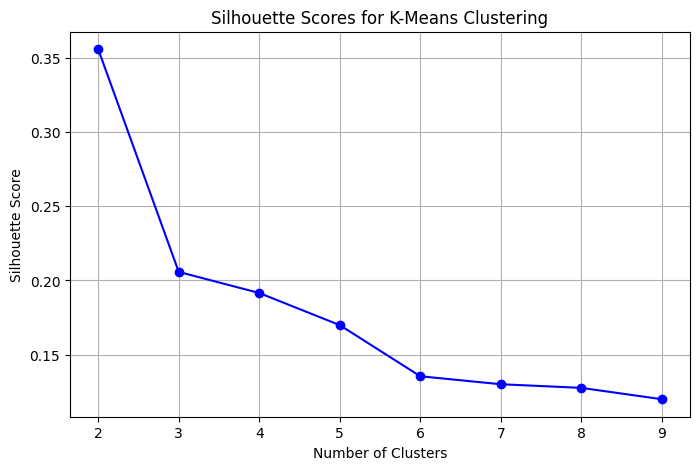

In [ ]:
# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:

# Apply K-Means clustering with the best number of clusters (based on silhouette score)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_data)


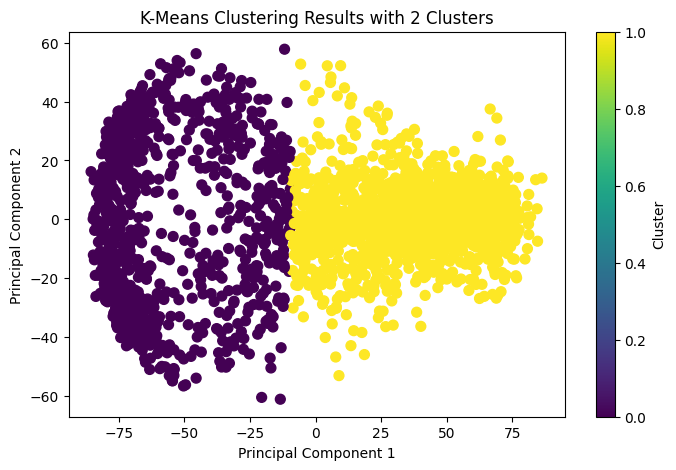

In [ ]:
# Plot K-Means clustering results
plt.figure(figsize=(8, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=50)
plt.title(f'K-Means Clustering Results with {optimal_clusters} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

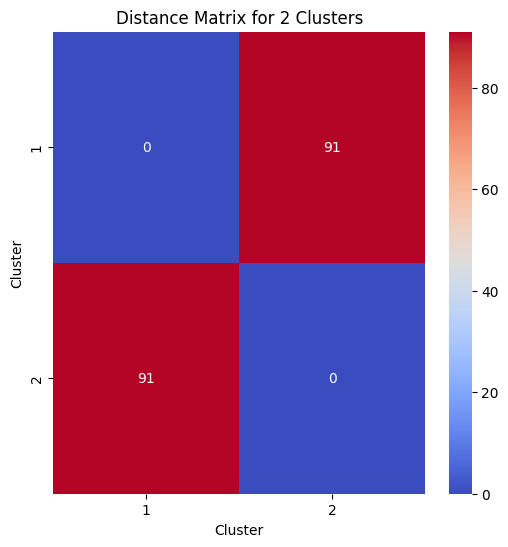

In [ ]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Select the best number of clusters based on silhouette score
best_k = 2  # Based on your output, this is the highest silhouette score (0.40)

# Perform K-Means clustering for the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans.fit(reduced_data)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance matrix between the cluster centers
dist_matrix = pairwise_distances(cluster_centers)

# Visualize the distance matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(dist_matrix, annot=True, cmap='coolwarm', xticklabels=range(1, best_k + 1), yticklabels=range(1, best_k + 1))
plt.title(f"Distance Matrix for {best_k} Clusters")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()
